In [60]:
import glob,os,h5py
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from pycbc.inference import io, models
from pycbc.workflow import WorkflowConfigParser
from pycbc import conversions
from pycbc.results import str_utils
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [2]:
import json

f = open('snrs.json')
 
# returns JSON object as
# a dictionary
snrs = json.load(f)

In [4]:
candidate = []
for key in snrs:
    if snrs[key] > 9:
        candidate.append(key)

In [76]:
candidate

['GW150914_095045',
 'GW190521_030229',
 'GW190521_074359',
 'GW191109_010717',
 'GW200129_065458',
 'GW200224_222234']

In [71]:
result_paths = {}
for v in snrs:
    path = glob.glob('./t10-4ogc-run/220_221_delta221/4ogcringdown_output/posterior_files/*'+v+'*.hdf')
    try:
        result_paths[v] = path[0]
    except IndexError:
        continue

In [72]:
result_paths

{'GW150914_095045': './t10-4ogc-run/220_221_delta221/4ogcringdown_output/posterior_files/H1L1V1-EXTRACT_POSTERIOR_GW150914_095045-1126259200-400.hdf',
 'GW170104_101158': './t10-4ogc-run/220_221_delta221/4ogcringdown_output/posterior_files/H1L1V1-EXTRACT_POSTERIOR_GW170104_101158-1126259200-400.hdf',
 'GW170403_230611': './t10-4ogc-run/220_221_delta221/4ogcringdown_output/posterior_files/H1L1V1-EXTRACT_POSTERIOR_GW170403_230611-1126259200-400.hdf',
 'GW170727_010430': './t10-4ogc-run/220_221_delta221/4ogcringdown_output/posterior_files/H1L1V1-EXTRACT_POSTERIOR_GW170727_010430-1126259200-400.hdf',
 'GW170729_185629': './t10-4ogc-run/220_221_delta221/4ogcringdown_output/posterior_files/H1L1V1-EXTRACT_POSTERIOR_GW170729_185629-1126259200-400.hdf',
 'GW170809_082821': './t10-4ogc-run/220_221_delta221/4ogcringdown_output/posterior_files/H1L1V1-EXTRACT_POSTERIOR_GW170809_082821-1126259200-400.hdf',
 'GW170818_022509': './t10-4ogc-run/220_221_delta221/4ogcringdown_output/posterior_files/H1L1V

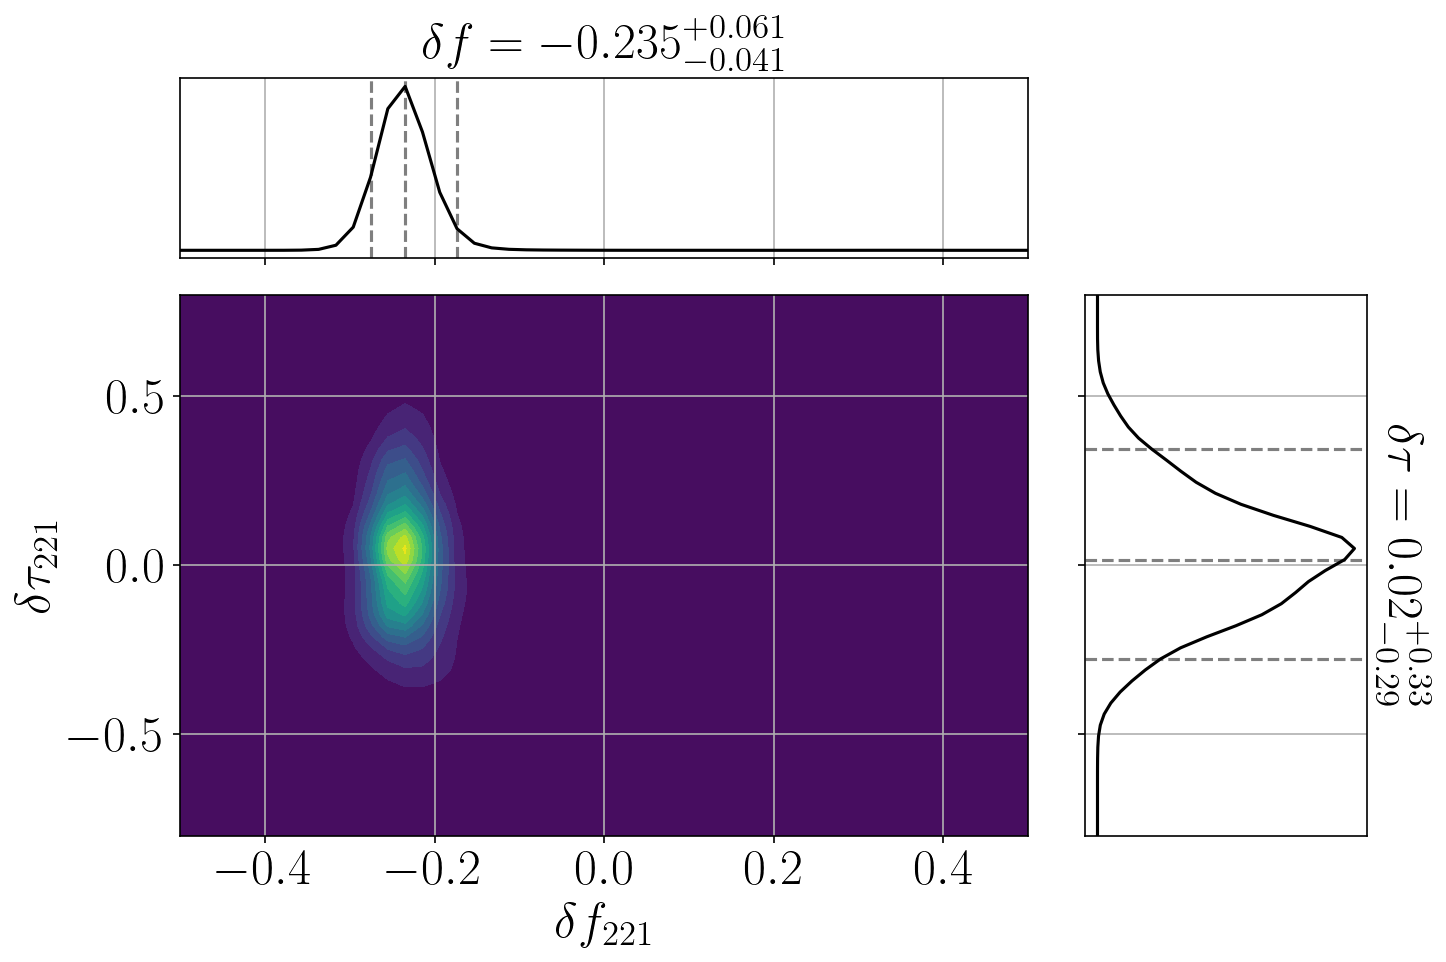

<Figure size 735.243x454.405 with 0 Axes>

In [75]:
posterior_pdfs, maxL_values = sample_kde_2D(result_paths)
cumulative_prod_posteriors_marg, cumulative_prod_posteriors_coord, percentiles_list, max_posterior = \
                                    plot_from_samples_kde_2D(
                                                             [posterior_pdfs],
                                                             [maxL_values],
                                                             output_path='figures',
                                                             image_type='.png',
                                                             savefig=False,
                                                             dev_lim=[[-0.5,0.5],[-0.8,0.8]],
                                                             plot_maxL=False,
                                                             make_plot=True)

# Function definition

In [61]:
def sample_kde_2D(result_paths, mode='221', dev_lim=[[-0.5,0.5],[-0.8,0.8]], pdf_samples=50):
    '''
    result_paths={event:path}
    dev_lim = [[deltaf_low, deltaf_high],[deltatau_low,deltatau_high]]
    '''
    maxL_values = {'delta_f': {}, 'delta_tau': {}}
    multi_kde = {}
    multi_pdf = {}

    # Coordinate grid for kde samples
    coords = {}
    coords['delta_f'], coords['delta_tau'] = \
    np.meshgrid(np.linspace(dev_lim[0][0], dev_lim[0][1], num=pdf_samples), 
                np.linspace(dev_lim[1][0], dev_lim[1][1], num=pdf_samples))

    # Read posterior files and produce posterior kdes.
    for event in result_paths:
        fp = io.loadfile(result_paths[event], 'r')
        samples = fp.read_samples(['delta_f'+mode,'delta_tau'+mode, 'loglikelihood'])#, temps=0)

        multi_kde[event] = stats.gaussian_kde([samples['delta_f'+mode], samples['delta_tau'+mode]])
        multi_pdf[event] = multi_kde[event].evaluate([coords['delta_f'].ravel(), coords['delta_tau'].ravel()])

        # rough normalisation, each pixel of same size, sum normalised to 1:
        multi_pdf[event] /= ( np.sum(multi_pdf[event]) * (dev_lim[0][1] - dev_lim[0][0]) * \
                                                         (dev_lim[1][1] - dev_lim[1][0]) / pdf_samples**2)

        maxL_idx = np.argmax(samples['loglikelihood'])

        maxL_values['delta_f'][event] = samples['delta_f'+mode][maxL_idx]
        maxL_values['delta_tau'][event] = samples['delta_tau'+mode][maxL_idx]

        fp.close()

    return multi_pdf, maxL_values

In [74]:
def plot_from_samples_kde_2D(pdfs, maxL, output_path, mode='221',image_type=".pdf",
                             savefig=False, dev_lim=[[-0.5,0.5],[-0.8,0.8]],
                             pdf_samples=50, plot_maxL=True, make_plot=True):
    '''pdfs : list
       ===========
       List of dictionaries. Each dictionary contains the posterior samples for all events
       to be combined. A plot is produced for each dictionary in the list, i.e. for different combinations.
       
       maxl : list
       ===========
       List of nested dictionaries. Top-level dictionary contains a dictionary for each delta parameter.
       Next level contains maxL values for each event to be combined.
    '''
    no_runs = len(pdfs)
    if make_plot:
        fig = plt.figure(figsize=(fig_width,fig_height*no_runs), facecolor='w')

    # Coordinate grid for kde samples
    coords = {}
    coords['delta_f'], coords['delta_tau'] = \
    np.meshgrid(np.linspace(dev_lim[0][0], dev_lim[0][1], num=pdf_samples), 
                np.linspace(dev_lim[1][0], dev_lim[1][1], num=pdf_samples))

    for run_idx in range(no_runs):

        maxL_values = {'delta_f': {}, 'delta_tau': {}}
        multi_pdf = pdfs[run_idx]
        max_posterior = {}

        if pdf_samples**2 != len(multi_pdf[list(multi_pdf.keys())[0]]):
            raise "Samples numbers do not match."
            #pass
        for event in multi_pdf:
            maxL_values['delta_f'][event] = maxL[run_idx]['delta_f'][event]
            maxL_values['delta_tau'][event] = maxL[run_idx]['delta_tau'][event]

            tmp_posterior_max = np.argmax(multi_pdf[event].flatten())
            max_posterior[event] = (coords['delta_f'].flatten()[tmp_posterior_max],
                                    coords['delta_tau'].flatten()[tmp_posterior_max])

        # NOTE: Assuming the product of posteriors is equal to the product of likelihoods because of flat prior.
        # So we directly take the product of the posteriors.
        cumulative_prod_posteriors = {}

        prod_posteriors = np.zeros(pdf_samples * pdf_samples)

        for event in multi_pdf:
            prod_posteriors += np.log(multi_pdf[event])
            prod_posteriors = np.exp(prod_posteriors)
            prod_posteriors /= np.sum(prod_posteriors)
            prod_posteriors = np.log(prod_posteriors)

            # Store posterior product at each step, take exponential, normalise, marginalise
            cumulative_prod_posteriors[event] = np.exp(prod_posteriors)
            cumulative_prod_posteriors[event] /= np.sum(cumulative_prod_posteriors[event])

        prod_posteriors = np.exp(prod_posteriors)
        prod_posteriors /= np.sum(prod_posteriors)

        tmp_posterior_max = np.argmax(prod_posteriors.flatten())
        max_posterior_combined = (coords['delta_f'].flatten()[tmp_posterior_max],
                                  coords['delta_tau'].flatten()[tmp_posterior_max])

        if make_plot:
            # Make 2D posterior plot
            widths = [3, 1]
            heights = [1, 3]*no_runs
            spec = fig.add_gridspec(ncols=2, nrows=2*no_runs,
                                    width_ratios=widths,
                                    height_ratios=heights)
            ax1 = fig.add_subplot(spec[(no_runs-1)*2+1,0])

            CS = ax1.contourf(coords['delta_f'], 
                         coords['delta_tau'], 
                         prod_posteriors.reshape([len(coords['delta_f']),len(coords['delta_tau'])]),
                         cmap=plt.cm.viridis, levels=20)
            if plot_maxL:
                ax1.scatter(maxL_values['delta_f'].values(), maxL_values['delta_tau'].values(), c='red', marker='x')
                for event in max_posterior:
                    ax1.scatter(max_posterior[event][0], max_posterior[event][1],
                                ec='green', marker='o', fc='none')
                ax1.scatter(max_posterior_combined[0], max_posterior_combined[1],
                            ec='red', marker='o', fc='none')
            ax1.set_xlabel("$\delta f_{221}$")
            ax1.set_ylabel("$\delta \\tau_{221}$")
    
    
        prod_posteriors_matrix = prod_posteriors.reshape([len(coords['delta_f']),len(coords['delta_tau'])])
        prod_posteriors_marg = {'delta_f':np.zeros(len(coords['delta_f'][0,:])), 
                                'delta_tau':np.zeros(len(coords['delta_tau'][:,0]))}

        # Find marginalised distributions
        for idx in range(len(coords['delta_f'][0,:])):
            prod_posteriors_marg['delta_f'][idx] = np.sum(prod_posteriors_matrix[:,idx])

        for idx in range(len(coords['delta_tau'][:,0])):
            prod_posteriors_marg['delta_tau'][idx] = np.sum(prod_posteriors_matrix[idx,:])

        # Find marginalised for cumulative distributions
        cumulative_prod_posteriors_matrix = {}
        cumulative_prod_posteriors_marg = {}
        for event in cumulative_prod_posteriors:
            cumulative_prod_posteriors_matrix[event] = cumulative_prod_posteriors[event].reshape([len(coords['delta_f']),len(coords['delta_tau'])])
            cumulative_prod_posteriors_marg[event] = {'delta_f':np.zeros(len(coords['delta_f'][0,:]))}

        for event in cumulative_prod_posteriors:
            for idx in range(len(coords['delta_f'][0,:])):
                cumulative_prod_posteriors_marg[event]['delta_f'][idx] = np.sum(cumulative_prod_posteriors_matrix[event][:,idx])

        # Find percentiles for distributions
        percentiles = {'delta_f':{0.05:None, 0.5:None, 0.95:None}, 'delta_tau':{0.05:None, 0.5:None, 0.95:None}}
        for idx in range(len(prod_posteriors_marg['delta_f'])):
            for perc in percentiles['delta_f'].keys():
                if np.sum(prod_posteriors_marg['delta_f'][0:idx]) < perc * np.sum(prod_posteriors_marg['delta_f'][:]):
                    percentiles['delta_f'][perc] = coords['delta_f'][0][idx]

        for idx in range(len(prod_posteriors_marg['delta_tau'])):
            for perc in percentiles['delta_tau'].keys():
                if np.sum(prod_posteriors_marg['delta_tau'][0:idx]) < perc * np.sum(prod_posteriors_marg['delta_tau'][:]):
                    percentiles['delta_tau'][perc] = coords['delta_tau'][:,0][idx]

        if make_plot:
            # Make marginalised posterior plot for delta_f
            ax = fig.add_subplot(spec[(no_runs-1)*2,0], sharex=ax1)
            ax.plot(coords['delta_f'][0], prod_posteriors_marg['delta_f'], color='k')
            for p in percentiles['delta_f']:
                if percentiles['delta_f'][p] is not None:
                    ax.axvline(x=percentiles['delta_f'][p], c='k', ls='--', alpha=0.5)

            ax.tick_params(labelbottom=False)
            ax.set_yticks([])
            ax.xaxis.set_label_position("top")
            ax.set_xlabel(r'$\delta f = '+str_utils.format_value(percentiles['delta_f'][0.5],
                                                               percentiles['delta_f'][0.5]-percentiles['delta_f'][0.05],
                                                               percentiles['delta_f'][0.95]-percentiles['delta_f'][0.5])+r'$',
                          va="bottom")

            # Make marginalised posterior plot for delta_tau
            ax = fig.add_subplot(spec[(no_runs-1)*2+1,1], sharey=ax1)
            ax.plot(prod_posteriors_marg['delta_tau'], coords['delta_tau'][:,0], color='k')
            for p in percentiles['delta_tau']:
                if percentiles['delta_tau'][p] is not None:
                    ax.axhline(y=percentiles['delta_tau'][p], c='k', ls='--', alpha=0.5)

            ax.tick_params(labelleft=False)
            ax.set_xticks([])
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(r'$\delta \tau = '+str_utils.format_value(percentiles['delta_tau'][0.5],
                                                               percentiles['delta_tau'][0.5]-percentiles['delta_tau'][0.05],
                                                               percentiles['delta_tau'][0.95]-percentiles['delta_tau'][0.5])+r'$',
                          va="bottom", rotation=270)

    
    if make_plot:
        fig.set_dpi(150)
        #fig.tight_layout()
        fig.subplots_adjust(left=0.125,
                            right=0.9,
                            bottom=0.1,
                            top=0.9,
                            wspace=0.1,
                            hspace=0.1)
        if savefig:
            fig.savefig(output_path+image_type, bbox_inches='tight')
        #else:
        plt.show()
        plt.clf()
    
    return cumulative_prod_posteriors_marg, coords['delta_f'][0,:], percentiles, (max_posterior, max_posterior_combined)